In [1]:
def random_forest_model(df, feat_to_drop, testing_size, feat_threshold=0, df_to_test=None, test_feat_drop=None):
    
    """
    about
    """
    """
    uses a built-in feature importance attribute that calculates feature importance scores for 
    each feature based on the quality of a node split in trees (gini)

    This can be used to determine what features might be able to be dropped from the model 
    
    Notes: 
    -feat_to_drop must include 'type'
    -Do not specify feat_threshold if you want to see feature importance scores
    -df and df_to_test must have same features using drop
    """
    
    import warnings
    warnings.filterwarnings('ignore', '.*has feature names.*', )
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.feature_selection import SelectFromModel
    import seaborn as sns
    
    X=df.drop(feat_to_drop, axis=1) #drop true classification from data along with features that are not important
    Y=df['type'].values #separate true classifications for fitting and evaluating the model

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = testing_size, random_state = 0)
    #split data into model training and model testing dataframes, random number seed of 0 
    
    rfc = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 
    
    """
    random state - set to either 0 or 42 is common, locks in the seed for a random number generator so 
    the same string of random numbers can be reproduced in the future. Used to create randomness in data selection
    and feature selection for each tree

    criterion - gini is default, entropy also used. Both are for classification. 

    reduce tree depth to simplify model and help with overfitting

    need to evaluate on training set - 100% on training is overfitting, low bias, high variance
    """
    
    rfc.fit(X_train, Y_train) #builds a forest of decision trees from the taining dataset 
   
    # For model with full features:
    if feat_threshold == 0: #39 sec to run with cat csv
        
        rfc_pred_train = rfc.predict(X_train) #predict classes for X using the fit 
        rfc_pred_test = rfc.predict(X_test)
        
        print("accuracy of model on training data =", rfc.score(X_train, Y_train)) # percent predictions that are correct
        print("accuracy of model on testing data =", rfc.score(X_test, Y_test))
        
        feature_importance = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=True)
        #use full feature model to evaluate importance of features and rank them low to high
    
        print('Feature importances: ', rfc.feature_importances_) 
        #values of relative feature importance scores, useful for threshold determination
        
        print(sns.barplot(x=feature_importance, y=feature_importance.index)) #visualization of feature importance
        plt.xlabel('Feature Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title("Visualizing Important Features", fontsize=15, pad=15)
        plt.show()
          
        #printed confusion matrix and normalized confusion matrix as well as heat maps for both
        title_options = [("Confusion Matrix", None), ("Normalized Confusion Matrix", "true")] 
        types = df['type'].unique()
        
        for title, normalize in title_options:
            disp = ConfusionMatrixDisplay.from_estimator(rfc, X_test, Y_test, display_labels=types, include_values=False, 
                cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)
            
    #for model with optimized features using a cutoff value (threshold) of feature importance scores, 
    #will not evaluate feature importance, go back to threshold of zero to see importance scores again   
    else: #105 sec to run with cat csv
        
        feature_selector = SelectFromModel(rfc, threshold = feat_threshold) 
        #removes features below threshold score
        
        important_features = feature_selector.fit_transform(X_train, Y_train) 
        test_imp_feat = feature_selector.fit_transform(X_test, Y_test)
        #update testing and training datasets to only include new set of features
        
        rfc2 = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 
        rfc2.fit(important_features, Y_train)
        #new rfc to train on new data

        rfc2_pred_train = rfc2.predict(important_features)
        rfc2_pred_test = rfc2.predict(test_imp_feat)
        
        print("accuracy of model on training data =", rfc2.score(important_features, Y_train)) 
        print("accuracy of model on testing data =", rfc2.score(test_imp_feat, Y_test))
        
        title_options = [("Confusion Matrix", None), ("Normalized Confusion Matrix", "true")] 
        types = df['type'].unique()
        
        for title, normalize in title_options:
            disp = ConfusionMatrixDisplay.from_estimator(rfc2, test_imp_feat, Y_test, display_labels=types, include_values=False, 
                cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)
            
    if type(df_to_test) == type(df):
        if test_feat_drop != None:
            if feat_threshold == 0:
            
                X_new_data = df_to_test.drop(test_feat_drop, axis=1) #test model on all data from a new data set
                Y_new_data = df_to_test['type'].values 

                rfc_pred_new = rfc.predict(X_new_data) #predict classes for new X data using the old fit 

                print("accuracy of model on new data =", rfc.score(X_new_data, Y_new_data)) # percent predictions that are correct


                title_options = [("Confusion Matrix New Data", None), ("Normalized Confusion Matrix New Data", "true")] 
                types = df['type'].unique()

                types_new = df_to_test['type'].unique()
                for title, normalize in title_options:
                    disp = ConfusionMatrixDisplay.from_estimator(rfc, X_new_data, Y_new_data, display_labels=types_new, include_values=False, 
                        cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
                    disp.ax_.set_title(title)

                    print(title)
                    print(disp.confusion_matrix)
                
    if type(df_to_test) == type(df):
        if test_feat_drop != None:
            if feat_threshold != 0:
                
                X_new_data = df_to_test.drop(test_feat_drop, axis=1) #test model on all data from a new data set
                Y_new_data = df_to_test['type'].values
                
                important_features_new = feature_selector.transform(X_new_data) #use selected features from fitting data 

                rfc_pred_new = rfc2.predict(important_features_new) #predict classes for new X data using the old fit 

                print("accuracy of model on new data =", rfc2.score(important_features_new, Y_new_data)) # percent predictions that are correct

                title_options = [("Confusion Matrix New Data", None), ("Normalized Confusion Matrix New Data", "true")] 

                types_new = df_to_test['type'].unique()
                for title, normalize in title_options:
                    disp = ConfusionMatrixDisplay.from_estimator(rfc2, important_features_new, Y_new_data, display_labels=types_new, include_values=False, 
                        cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
                    disp.ax_.set_title(title)

                    print(title)
                    print(disp.confusion_matrix)


        

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

accuracy of model on training data = 1.0
accuracy of model on testing data = 0.890018484288355
Confusion Matrix
[[  6   3   0   1   3   0   0   0   3   1   1]
 [  0 122   0   3   1   0   6   0   0   0   0]
 [  0   4   2   0   0   0   2   0   0   0   1]
 [  4   0   0  62   8   0   6   0   3   0   0]
 [  1   8   0   4 175   0  11   0   0   0   0]
 [  0   0   0   0   0 176   0   0   0   0   0]
 [  0   7   0   0  19   0 403   0   0   0   0]
 [  1   1   0   1   3   0   3   1   1   0   0]
 [  3   0   0   0   0   0   0   0  11   0   2]
 [  0   0   0   0   0   1   0   0   1   0   0]
 [  0   0   1   0   0   1   0   0   0   0   5]]
Normalized Confusion Matrix
[[0.33333333 0.16666667 0.         0.05555556 0.16666667 0.
  0.         0.         0.16666667 0.05555556 0.05555556]
 [0.         0.92424242 0.         0.02272727 0.00757576 0.
  0.04545455 0.         0.         0.         0.        ]
 [0.         0.44444444 0.22222222 0.         0.         0.
  0.22222222 0.         0.         0.         

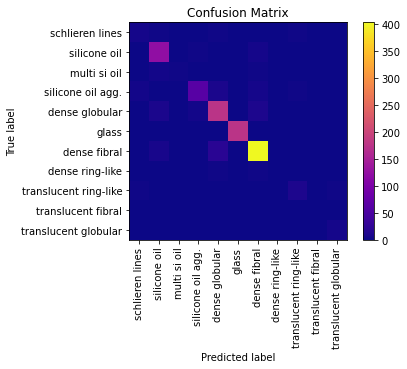

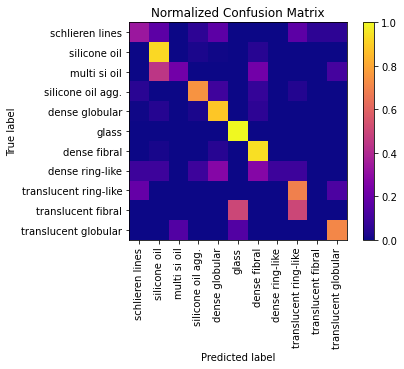

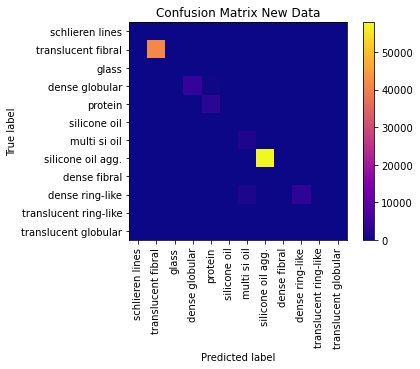

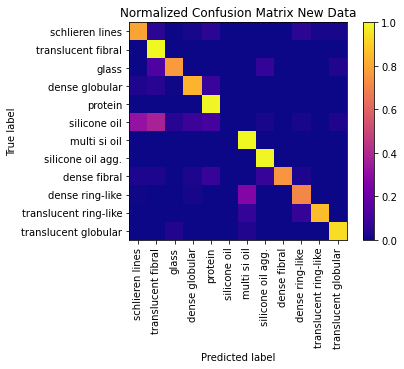

In [3]:
from timeit import default_timer as timer
start = timer()

#-------------------------------------------------------------------------------------------------------------

df_h = pd.read_csv('categorized_particles_101.csv') #data categorized by humans, model trained on this
df_h.type.values.reshape(-1, 1).shape

feat_to_drop = ['type','step','experiment','particle_id','ml_type_proba'] #features dropped from human categorized, has extra ml_type_proba feature 

#-------------------------------------------------------------------------------------------------------------

df = pd.read_csv('categorized_particles.csv') #data categorized by other ML model, new data to test model on
df.type.values.reshape(-1, 1).shape

test_feat_drop = ['type','step','experiment','particle_id'] #features dropped from ML categorized

#-------------------------------------------------------------------------------------------------------------

random_forest_model(df_h, feat_to_drop, 0.3, 0.05, df, test_feat_drop)

end = timer()
print("run time =",end - start," seconds")